# Overview
In this notebook we explore the concept of Principal Component Analysis. This is a popular feature engineering technique used specifically for dimentionality reduction. In short, PCA will try to measure the importance of a feature using a measurement similar to correlation. 

## Prerequisite Reading
If you are unfamiliar with correlation it is suggested you read the [notebook on correlation](Correlation.ipynb). As correlation is affected by linear scale, we will see that normalization is a prerequisite transformation for our data. If you are not famliar with normalization it is suggested you reat the [notebook on normalization](../Exploratory%20Data%20Analysis%20%28EDA%29%2F/Normalization.ipynb)

This notebook is broken down into the following sections:
1. Loading our data
2. Normalizing our data


# Step 1. Load our data

In [1]:
# Load our libraires
import pandas
import numpy

In [2]:
# Load our sample data
import os
import pyprojroot
project_root_dir = pyprojroot.here()
input_file_path = os.path.join(project_root_dir, "Example Data Sets", "Test Scores.csv")
delimiter = ","
df = pandas.read_csv(input_file_path, delimiter=delimiter)
df

,ACT,FinalExam,QuizAvg,TestAvg
0,33,181,95,89
1,31,169,81,89
2,21,176,65,68
3,25,181,66,90
4,29,169,89,81
5,24,103,61,57
6,25,150,81,76
7,29,147,86,76
8,36,181,98,102
9,26,163,72,70


# Step 2. Normalize Our Data
In order to use PCA we need to take care to appropriately normalize our data. In a nutshell, the PCA algorithm relies on linear distance of the deviations of our variables; variables with different scales will disproportionately report deviations and thus will introduce bias into the analysis (penalizing variables with smaller scale). Normalization removes this problem by adjusting variables to a common (or similar enough) scale. If you are not famliar with normalization it is suggested you reat the [notebook on normalization](../Exploratory%20Data%20Analysis%20%28EDA%29%2F/Normalization.ipynb).


## 2.1 Choose a normalization method
There are many ways to normalize or standardiaze our data. We will not talk about all the approaches here... but there are a few and they all have different affects and implications. We will choose standardization.

### 2.3 Normalize using a Standard Score
We will use the **standard score** (z-score) because it is simple and well documented.

The standard score is the signed fractional number of standard deviations by which the value of an observation or data point is above or below the mean value of what is being observed or measured. Observed values above the mean have positive standard scores, while values below the mean have negative standard scores.

$$ z = \frac{(x-\mu)}{\sigma} $$

The higher or lower the score, the farther from the mean, and thus the more exceptional a given score is when compared to the sample. This is how we will compare our scores!!

If we look at a sample with a normally distributed random variable, we will see the implications of the various scores:

![image](Normalization_method_comparison.png)

We calculate the standard score of each element in our data frame (on a per-column basis)

In [3]:
normalized_df = ((df - df.mean())/df.std())
normalized_df

,ACT,FinalExam,QuizAvg,TestAvg
0,1.270931,0.940813,1.304131,0.952737
1,0.790038,0.481346,0.285766,0.952737
2,-1.614426,0.749368,-0.878080,-0.638767
3,-0.652640,0.940813,-0.805340,1.028523
4,0.309145,0.481346,0.867689,0.346450
5,-0.893087,-2.045721,-1.169041,-1.472411
6,-0.652640,-0.246143,0.285766,-0.032480
7,0.309145,-0.361010,0.649467,-0.032480
8,1.992270,0.940813,1.522352,1.937953
9,-0.412194,0.251613,-0.368898,-0.487195


# Step 3. Calculate Correlation Matrix
As we will see, PCA is reliant on the pearson correlation coefficient. We can calculate the correlation between pairs of variables. When dealing with more than one pair, a correlation matrix is a convenient way of tracking the information.

The correlation matrix, a type of adjacency matrix, allows us to show the correlation between all variables in a sample set using a compact format. Each row and column pertain to a particular variable, the cells indicate the correlation between the two points.

We can easily calculate correlation using numpy or pandas. We will look at both methods.

## 3.1. Calculate Correlation Using Numpy
Numpy provides a method for calculating covariance and returing a correlation matrix represented by a numpy array. It's not as nice to look at, but sometimes numpy objects are needed. The rows/columns match those of our data frame. We see a diagonal set of 1's indicating that variable A is adjacent to itself in that cell.

In [4]:
# Take the transpose of our matrix (not important to understand why we are doing this)
normalized_transposed_df = normalized_df.T

# Compute the correlation matrix (a numpy ndarray)
correlation_numpy_array = numpy.corrcoef(normalized_transposed_df)
correlation_numpy_array

array([[1.        , 0.33618637, 0.82780343, 0.7102748 ],
       [0.33618637, 1.        , 0.49994932, 0.79584684],
       [0.82780343, 0.49994932, 1.        , 0.7486962 ],
       [0.7102748 , 0.79584684, 0.7486962 , 1.        ]])

In [5]:
# Show the rows and columns in order
print(list(normalized_df.columns))

['ACT', 'FinalExam', 'QuizAvg', 'TestAvg']


## 3.2. Calculate Correlation Using Pandas
Pandas is a little more user friendly because it requires less knowledge of matrix algebra (the transpose) and it tells us the row and column names upfront.

In [6]:
# Convert the numpy array into a pandas data frame
correlation_df = normalized_df.corr()
correlation_df

,ACT,FinalExam,QuizAvg,TestAvg
ACT,1.000000,0.336186,0.827803,0.710275
FinalExam,0.336186,1.000000,0.499949,0.795847
QuizAvg,0.827803,0.499949,1.000000,0.748696
TestAvg,0.710275,0.795847,0.748696,1.000000


We see that QuizAvg and ACT have the highest correlation meaning that they are likely to be redundant features. There is only a small benefit to including both because one of them give us most of the information about the deviations of the other.

# Step 4. Decompose Eigenvalues and Eigenvectors

This step is the heart of PCA. In short, the eigenvalues/eigenvector decomposition provides us a a way of eliminating features which provide duplicate data.

Mathematically eigenvalues and eivenvectors allows us to selectively reduce the number of dimensions in our problem while minimizing (and thus quantifying) information loss. The information being considered in the case of PCA is that of the correlation matrix. Thus any redundancy is that of correlation. By reducing the dimensionality we are reducing the overall covariance explained by our feature set.

## 4.3. Using Numpy To Calculate eigenvalues

We can use a builtin numpy function to do the decomposition:

https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eig.html

In [8]:
# Do the decomposition
#
#    Note: The term right vector just refers to the orientation of rows vs columns
#          This is part of the math that we just do not need to worry about
#

eigenvalues_numpy_array, right_eigenvectors_numpy_array = numpy.linalg.eig(correlation_numpy_array)

In [9]:
# Look at our lamndas (eigenvalues)
eigenvalues_df = pandas.DataFrame(eigenvalues_numpy_array, index=df.columns, columns=["eigenvalue"])
eigenvalues_df

,eigenvalue
ACT,2.978867
FinalExam,0.762946
QuizAvg,0.083230
TestAvg,0.174956


## 4.4. Calculate Proportion Of Variance Explained
If we look at the eigenvalues as being a measure of variance explained by a feature, we can cauluate the proportion of information explained by dividing the eigenvalue by the total sum of eigenvalues.

In [10]:
total_variance = eigenvalues_df["eigenvalue"].sum()
proportion_variance_explained_df = eigenvalues_df / total_variance
proportion_variance_explained_df = proportion_variance_explained_df.sort_values(by=["eigenvalue"], ascending=False)
proportion_variance_explained_df

,eigenvalue
ACT,0.744717
FinalExam,0.190737
TestAvg,0.043739
QuizAvg,0.020807


We can see that the proportions sum to 1. Note: Rounding errors are due to numpy's numerical implimentation of floating point numbers.

In [11]:
proportion_variance_explained_df["eigenvalue"].sum()

1.0000000000000002

# Step 5. Select the Principal Components
## 5.1. Frame the problem as an optimization problem
As with most problems, selecting the principal components is an optimization problem. If you are not familiar with optimization, see the [coresponding notebook](../Optimization/Optimization.ipynb).

We want to maximize the amount of variance explained or to minimize the information lost by removing a feature.

Looking at the proportion of information explained we see the following plot which can be optimized.

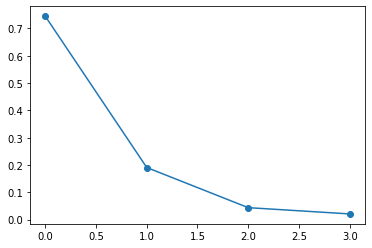

In [12]:
import matplotlib.pyplot as pyplot
fig, ax = pyplot.subplots()


x = []
y = []

for i, proportion in enumerate(proportion_variance_explained_df["eigenvalue"]):
    x.append(i)
    y.append(proportion)

ax.plot(x, y)
ax.scatter(x, y);

## 5.2. Select An Optimization Technique
As mentioned earlier, the [optimization notebook](../Optimization/Optimization.ipynb) discusses various methods for optimizing. In our case we need to select a cutoff point for an asymtotic function.

In our case we will choose to drop the last parameter with the smallest eigenvalue.